This code is related to Fig. 3c and Extended Data Fig. 7b

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/ACG Lab/Dyakov et al 2023 (google drive version)/v2_dataset/IDR')

!pip install metapredict

run this first section to generate the pickle file.

The code will print the dictionary of gene names and their corresponding IDR percentages after parsing the FASTA file. This helps you verify that the parsing and calculation were successful.

The pickle file, named gene_idr_percentages.pkl, will be saved in the same directory as your script unless you specify a different path.

# Pickle file generation

Only need to run this once and generate the .pkl file, which can be kept in the directory for these code snippets

In [ ]:
import metapredict as mp
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

def parse_fasta(filename):
    with open(filename, 'r') as file:
        contents = file.read().strip().split('>')
        gene_idr = {}
        for entry in contents:
            if entry.strip():  # Check if entry is not just whitespace
                parts = entry.split('\n', 1)
                if len(parts) < 2:  # If there are not enough parts, skip this entry
                    print(f"Skipping malformed entry: {entry[:50]}...")  # Print part of the malformed entry
                    continue
                header, sequence = parts
                sequence = sequence.replace('\n', '')
                gene_name = None
                # Extract the gene name from the header
                for part in header.split():
                    if part.startswith('GN='):
                        gene_name = part[3:]
                        break
                if gene_name:
                    try:
                        # Calculate IDR percentage and store in dictionary
                        gene_idr[gene_name] = mp.percent_disorder(sequence)
                    except ValueError as e:
                        print(f"Skipping {gene_name}: {e}")
        return gene_idr


def save_as_pickle(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)

# Path to your FASTA file
fasta_filename = 'UP000005640_9606.fasta'
# Path where the pickle file will be saved
pickle_filename = 'gene_idr_percentages.pkl'

# Parse the FASTA file and calculate IDR percentages
gene_idr_dict = parse_fasta(fasta_filename)

print(gene_idr_dict)
# Save the results to a pickle file
save_as_pickle(gene_idr_dict, pickle_filename)

#creating plots: original working code by vesal

ensure the cluster/gene list csv and rna_celline csv are in the directory. the cell map, sg map, and full protein list for the paper are added to 7013_cleaned_v2_NMF_19_top10-07-005_clusters_plus_datasets.csv already.

In [ ]:
import metapredict as mp
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Matplotlib to not convert text to paths in SVG output
plt.rcParams['svg.fonttype'] = 'none'

# Load the pickle file
with open('gene_idr_percentages.pkl', 'rb') as file:
    disorder_data = pickle.load(file)

# Read the CSV file for clusters
df = pd.read_csv('7013_cleaned_v2_NMF_19_top10-07-005_clusters_plus_datasets.csv')

# Prepare data for plotting
plot_data = []

# Entire proteome
entire_proteome_df = pd.DataFrame({
    'Disorder Percentage': list(disorder_data.values()),
    'Cluster': 'Entire Proteome'
})
plot_data.append(entire_proteome_df)

# Read the CSV file for HEK 293 data
hek_df = pd.read_csv('rna_celline.csv')

# Filter for HEK 293 cells and Value >= 2.5
hek_filtered = hek_df[(hek_df['Sample'] == 'HEK 293') & (hek_df['Value'] >= 2.5)]

# Get the list of genes in 'Gene name' column and map to disorder percentages
hek_disorder_percentages = [disorder_data.get(gene) for gene in hek_filtered['Gene name'] if gene in disorder_data]
hek_proteome_df = pd.DataFrame({
    'Disorder Percentage': hek_disorder_percentages,
    'Cluster': 'HEK 293'
})
plot_data.append(hek_proteome_df)

# Dictionary mapping indices to new cluster names
cluster_names = {
    0: '0 (Paraspeckle)', 1: '1 (Chromosome)', 2: '2 (TF-Paraspeckle)', 3: '3 (ER-Nuclear Membrane)', 4: '4 (Nucleolus)',
    5: '5 (Cytoplasmic RNP granule)', 6: '6 (Splicing)', 7: '7 (Cytoskeleton-Centrosome)', 8: '8 (DNA damage)',
    9: '9 (Transcription Reg.)', 10: '10 (Cajal body)', 11: '11 (RNA Export-Nucleoplasm)', 12: '12 (Nuclear Speckle)',
    13: '13 (Nuclear Pore-Envelope)', 14: '14 (PML Body)', 15: '15 (ER-Nucleolus)', 16: '16 (Translation)', 17: '(17 Polycomb)',
    18: '18 (Other/DNA binding)', 19: 'Cell map significant preys', 20: 'SG map signficant preys', 21: 'All significant preys'
}

# Iterate through each column (cluster) in the dataframe
for idx, column in enumerate(df.columns):
    proteins = df[column].dropna()  # Drop NA values
    disorder_percentages = [disorder_data.get(protein) for protein in proteins if disorder_data.get(protein) is not None]
    cluster_name = cluster_names.get(idx, column)  # Get new name or use existing
    cluster_df = pd.DataFrame({
        'Disorder Percentage': disorder_percentages,
        'Cluster': cluster_name
    })
    plot_data.append(cluster_df)

# Concatenate all dataframes into a single dataframe for plotting
plot_df = pd.concat(plot_data)

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Disorder Percentage', data=plot_df, palette='Blues')
plt.title('Distribution of Disorder Percentages')
plt.xlabel('Cluster')
plt.ylabel('Fraction of disordered regions')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()
#plt.savefig('idr_domains_extended_clusters.png', dpi=300)
plt.show()
plt.savefig('idr_domains_extended_clusters.svg', dpi=300)
plt.clf()

In [ ]:
print(len(entire_proteome_df))

20301


In [ ]:
## I think this is rough draft code for an intial violin plot by vesal.
## It is buried here in case we need it later

import metapredict as mp
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load the pickle file
with open('gene_idr_percentages.pkl', 'rb') as file:
    disorder_data = pickle.load(file)

# Read the CSV file
df = pd.read_csv('7013_cleaned_v2_NMF_19_top10-07-005_clusters_plus_datasets.csv')

# Prepare data for plotting
plot_data = []

# Iterate through each column (cluster) in the dataframe
for column in df.columns:
    # Get the list of proteins in the cluster
    proteins = df[column].dropna()  # Drop NA values
    # Map proteins to disorder percentages
    disorder_percentages = [disorder_data.get(protein) for protein in proteins if disorder_data.get(protein) is not None]
    plot_data.append(pd.DataFrame({
        'Disorder Percentage': disorder_percentages,
        'Cluster': column
    }))

# Concatenate all dataframes into a single dataframe for plotting
plot_df = pd.concat(plot_data)

# Create the violin plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Disorder Percentage', data=plot_df)
plt.title('Distribution of Disorder Percentages by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage of Disordered Region')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.savefig('idr_domains_clusters.png')
plt.clf()

updated by Boris: boxplots v1

In [ ]:
import metapredict as mp
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Matplotlib to not convert text to paths in SVG output
plt.rcParams['svg.fonttype'] = 'none'

# Load the pickle file
with open('gene_idr_percentages.pkl', 'rb') as file:
    disorder_data = pickle.load(file)

# Read the CSV file for clusters
df = pd.read_csv('7013_cleaned_v2_NMF_19_top10-07-005_clusters_plus_datasets.csv')

# Prepare data for plotting
plot_data = []

# Entire proteome
entire_proteome_df = pd.DataFrame({
    'Disorder Percentage': list(disorder_data.values()),
    'Cluster': 'Entire Proteome'
})
plot_data.append(entire_proteome_df)

# Read the CSV file for HEK 293 data
hek_df = pd.read_csv('rna_celline.csv')

# Filter for HEK 293 cells and Value >= 2.5
hek_filtered = hek_df[(hek_df['Sample'] == 'HEK 293') & (hek_df['Value'] >= 2.5)]

# Get the list of genes in 'Gene name' column and map to disorder percentages
hek_disorder_percentages = [disorder_data.get(gene) for gene in hek_filtered['Gene name'] if gene in disorder_data]
hek_proteome_df = pd.DataFrame({
    'Disorder Percentage': hek_disorder_percentages,
    'Cluster': 'HEK 293'
})
plot_data.append(hek_proteome_df)

# Dictionary mapping indices to new cluster names
cluster_names = {
    0: '0 (Paraspeckle)', 1: '1 (Chromosome)', 2: '2 (TF-Paraspeckle)', 3: '3 (ER-Nuclear Membrane)', 4: '4 (Nucleolus)',
    5: '5 (Cytoplasmic RNP granule)', 6: '6 (Splicing)', 7: '7 (Cytoskeleton-Centrosome)', 8: '8 (DNA damage)',
    9: '9 (Transcription Reg.)', 10: '10 (Cajal body)', 11: '11 (RNA Export-Nucleoplasm)', 12: '12 (Nuclear Speckle)',
    13: '13 (Nuclear Pore-Envelope)', 14: '14 (PML Body)', 15: '15 (ER-Nucleolus)', 16: '16 (Translation)', 17: '(17 Polycomb)',
    18: '18 (Other/DNA binding)', 19: 'Cell map significant preys', 20: 'SG map signficant preys', 21: 'All significant preys'
}

# First, create a list to hold dataframes temporarily
temp_data = []

# Iterate through each column (cluster) in the dataframe
for idx, column in enumerate(df.columns):
    proteins = df[column].dropna()  # Drop NA values
    disorder_percentages = [disorder_data.get(protein) for protein in proteins if disorder_data.get(protein) is not None]
    cluster_name = cluster_names.get(idx, column)  # Get new name or use existing
    cluster_df = pd.DataFrame({
        'Disorder Percentage': disorder_percentages,
        'Cluster': cluster_name
    })
    # Append to temporary data list
    temp_data.append(cluster_df)

# Sorting clusters 0 to 18 by median Disorder Percentage
sorted_temp_data = sorted(temp_data[:-3], key=lambda x: x['Disorder Percentage'].median(), reverse=True)

# Append special clusters (19, 20, 21) first, then sorted clusters
plot_data += sorted_temp_data + temp_data[-3:]

# Concatenate all dataframes into a single dataframe for plotting
plot_df = pd.concat(plot_data)

# Create the box plot with uniform color
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Disorder Percentage', data=pd.concat(plot_data), color='lightblue')
plt.title('Distribution of Disorder Percentages')
plt.xlabel('Cluster')
plt.ylabel('Fraction of disordered regions')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()
plt.savefig('idr_domains_extended_clusters.svg', dpi=300)
plt.clf()

# Violin plot for IDRs (used for Fig. 3c)

<ipython-input-26-7a7bb3d910b3>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Cluster', y='Disorder Percentage', data=plot_df, palette="pastel", cut=0) #  inner="quartile" can be used too


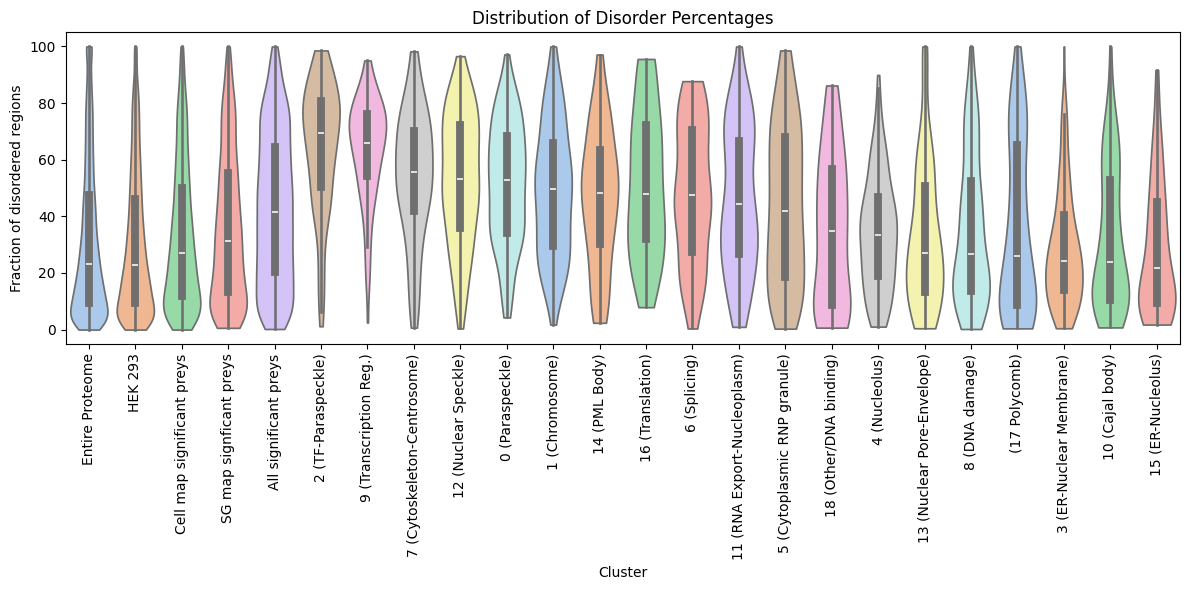

<Figure size 640x480 with 0 Axes>

In [ ]:
os.chdir('/content/drive/MyDrive/ACG Lab/Dyakov et al 2023 (google drive version)/v2_dataset/IDR')

import metapredict as mp
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Matplotlib to not convert text to paths in SVG output
plt.rcParams['svg.fonttype'] = 'none'

# Load the pickle file
with open('gene_idr_percentages.pkl', 'rb') as file:
    disorder_data = pickle.load(file)

# Read the CSV file for clusters
df = pd.read_csv('7013_cleaned_v2_NMF_19_top10-07-005_clusters_plus_datasets.csv')

# Prepare data for plotting
plot_data = []

# Entire proteome
entire_proteome_df = pd.DataFrame({
    'Disorder Percentage': list(disorder_data.values()),
    'Cluster': 'Entire Proteome'
})
plot_data.append(entire_proteome_df)

# Read the CSV file for HEK 293 data
hek_df = pd.read_csv('rna_celline.csv')

# Filter for HEK 293 cells and Value >= 2.5
hek_filtered = hek_df[(hek_df['Sample'] == 'HEK 293') & (hek_df['Value'] >= 2.5)]

# Get the list of genes in 'Gene name' column and map to disorder percentages
hek_disorder_percentages = [disorder_data.get(gene) for gene in hek_filtered['Gene name'] if gene in disorder_data]
hek_proteome_df = pd.DataFrame({
    'Disorder Percentage': hek_disorder_percentages,
    'Cluster': 'HEK 293'
})
plot_data.append(hek_proteome_df)

# Dictionary mapping indices to new cluster names
cluster_names = {
    0: '0 (Paraspeckle)', 1: '1 (Chromosome)', 2: '2 (TF-Paraspeckle)', 3: '3 (ER-Nuclear Membrane)', 4: '4 (Nucleolus)',
    5: '5 (Cytoplasmic RNP granule)', 6: '6 (Splicing)', 7: '7 (Cytoskeleton-Centrosome)', 8: '8 (DNA damage)',
    9: '9 (Transcription Reg.)', 10: '10 (Cajal body)', 11: '11 (RNA Export-Nucleoplasm)', 12: '12 (Nuclear Speckle)',
    13: '13 (Nuclear Pore-Envelope)', 14: '14 (PML Body)', 15: '15 (ER-Nucleolus)', 16: '16 (Translation)', 17: '(17 Polycomb)',
    18: '18 (Other/DNA binding)', 19: 'Cell map significant preys', 20: 'SG map signficant preys', 21: 'All significant preys'
}

# First, create a list to hold dataframes temporarily
temp_data = []

# Iterate through each column (cluster) in the dataframe
for idx, column in enumerate(df.columns):
    proteins = df[column].dropna()  # Drop NA values
    disorder_percentages = [disorder_data.get(protein) for protein in proteins if disorder_data.get(protein) is not None]
    cluster_name = cluster_names.get(idx, column)  # Get new name or use existing
    cluster_df = pd.DataFrame({
        'Disorder Percentage': disorder_percentages,
        'Cluster': cluster_name
    })
    # Append to temporary data list
    temp_data.append(cluster_df)

# Sorting clusters 0 to 18 by median Disorder Percentage
sorted_temp_data = sorted(temp_data[:-3], key=lambda x: x['Disorder Percentage'].median(), reverse=True)

# Append special clusters (19, 20, 21) first, then sorted clusters
plot_data += temp_data[-3:] + sorted_temp_data

# Concatenate all dataframes into a single dataframe for plotting
plot_df = pd.concat(plot_data)

# Create the violin plot with uniform color
plt.figure(figsize=(12, 6))
sns.violinplot(x='Cluster', y='Disorder Percentage', data=plot_df, palette="pastel", cut=0) #  inner="quartile" can be used too
plt.title('Distribution of Disorder Percentages')
plt.xlabel('Cluster')
plt.ylabel('Fraction of disordered regions')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.savefig('idr_fraction_violin.png', dpi=300)
plt.savefig('idr_fraction_violin.svg', dpi=300)
plt.show()
plt.clf()

# some other options for violin plots:
#sns.violinplot(x='Cluster', y='Disorder Percentage', data=plot_df, palette=sns.cubehelix_palette(len(plot_df['Cluster'].unique())))
#sns.violinplot(x='Cluster', y='Disorder Percentage', data=plot_df, palette=sns.husl_palette(len(plot_df['Cluster'].unique())))
#sns.violinplot(x='Cluster', y='Disorder Percentage', data=plot_df,  color="lightgrey", cut=0) #  inner="quartile" can be used too
#sns.violinplot(x='Cluster', y='Disorder Percentage', data=plot_df, color="lightgrey", cut=0, width=0.8)
#sns.violinplot(x='Cluster', y='Disorder Percentage', data=plot_df, color="#d3d3d3", cut=0, width=1)

# violin plots for LLPhyScore (used for Extended Data Fig. 7b)

## Convert LLPhyScore supp table 3 uniprot IDs to gene names
See PMID [36009025](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9405563/)

In [ ]:
import os
import csv

def parse_fasta(fasta_file_path):
    """ Parses the FASTA file to extract Uniprot ID to Gene name mapping, formatted to match CSV IDs. """
    uniprot_to_gene = {}
    with open(fasta_file_path, 'r') as file:
        for line in file:
            if line.startswith('>'):
                try:
                    parts = line.split('|')
                    uniprot_id = parts[1] + '_' + parts[2].split(' ')[0]
                    gene_name = next((part[3:] for part in line.split() if part.startswith('GN=')), None)
                    if gene_name:
                        uniprot_to_gene[uniprot_id] = gene_name
                except Exception as e:
                    print(f"Error parsing line: {line.strip()} | Error: {e}")
    print("Sample dictionary entries:", list(uniprot_to_gene.items())[:5])
    return uniprot_to_gene

def update_csv_with_genes(csv_file_path, output_csv_file_path, uniprot_to_gene):
    """ Update CSV by replacing Uniprot IDs with gene names in column 0. """
    with open(csv_file_path, 'r', newline='') as infile, open(output_csv_file_path, 'w', newline='') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        unmatched_ids = []  # To log unmatched IDs
        for row in reader:
            uniprot_id = row[0]
            if uniprot_id in uniprot_to_gene:
                print(f"Match found: {uniprot_id} -> {uniprot_to_gene[uniprot_id]}")  # Debug: Print match
                row[0] = uniprot_to_gene[uniprot_id]
            else:
                unmatched_ids.append(uniprot_id)
                print(f"No match for: {uniprot_id}")  # Debug: Print no match
            writer.writerow(row)
        print(f"Unmatched IDs: {list(set(unmatched_ids))[:20]}")  # Print unmatched IDs

# Set directory for files
os.chdir('/content/drive/MyDrive/ACG Lab/Dyakov et al 2023 (google drive version)/v2_dataset/LLPS prediction')

# Usage
fasta_file = 'File_S4_20380 human sequences.fasta'
csv_file = 'LLPhyScore_TS3.csv'
output_csv_file = 'LLPhyScore_TS3_IDtoGene.csv'

uniprot_to_gene_map = parse_fasta(fasta_file)
update_csv_with_genes(csv_file, output_csv_file, uniprot_to_gene_map)


## create plots

Columns in clusters_df: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', 'cell map signif preys',
       'sg map signif preys', 'all signif preys'],
      dtype='object')
Immediately after assignment, 0 (Paraspeckle) has 131 entries
Immediately after assignment, 1 (Chromosome) has 124 entries
Immediately after assignment, 2 (TF-Paraspeckle) has 170 entries
Immediately after assignment, 3 (ER-Nuclear Membrane) has 217 entries
Immediately after assignment, 4 (Nucleolus) has 160 entries
Immediately after assignment, 5 (Cytoplasmic RNP granule) has 140 entries
Immediately after assignment, 6 (Splicing) has 88 entries
Immediately after assignment, 7 (Cytoskeleton-Centrosome) has 104 entries
Immediately after assignment, 8 (DNA damage) has 119 entries
Immediately after assignment, 9 (Transcription Reg.) has 105 entries
Immediately after assignment, 10 (Cajal body) has 104 entries
Immediately after assignment, 11 (RNA Export

<ipython-input-63-760162e56a03>:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Cluster', y='8-feature Rank', data=plot_df, palette='pastel', cut=0)


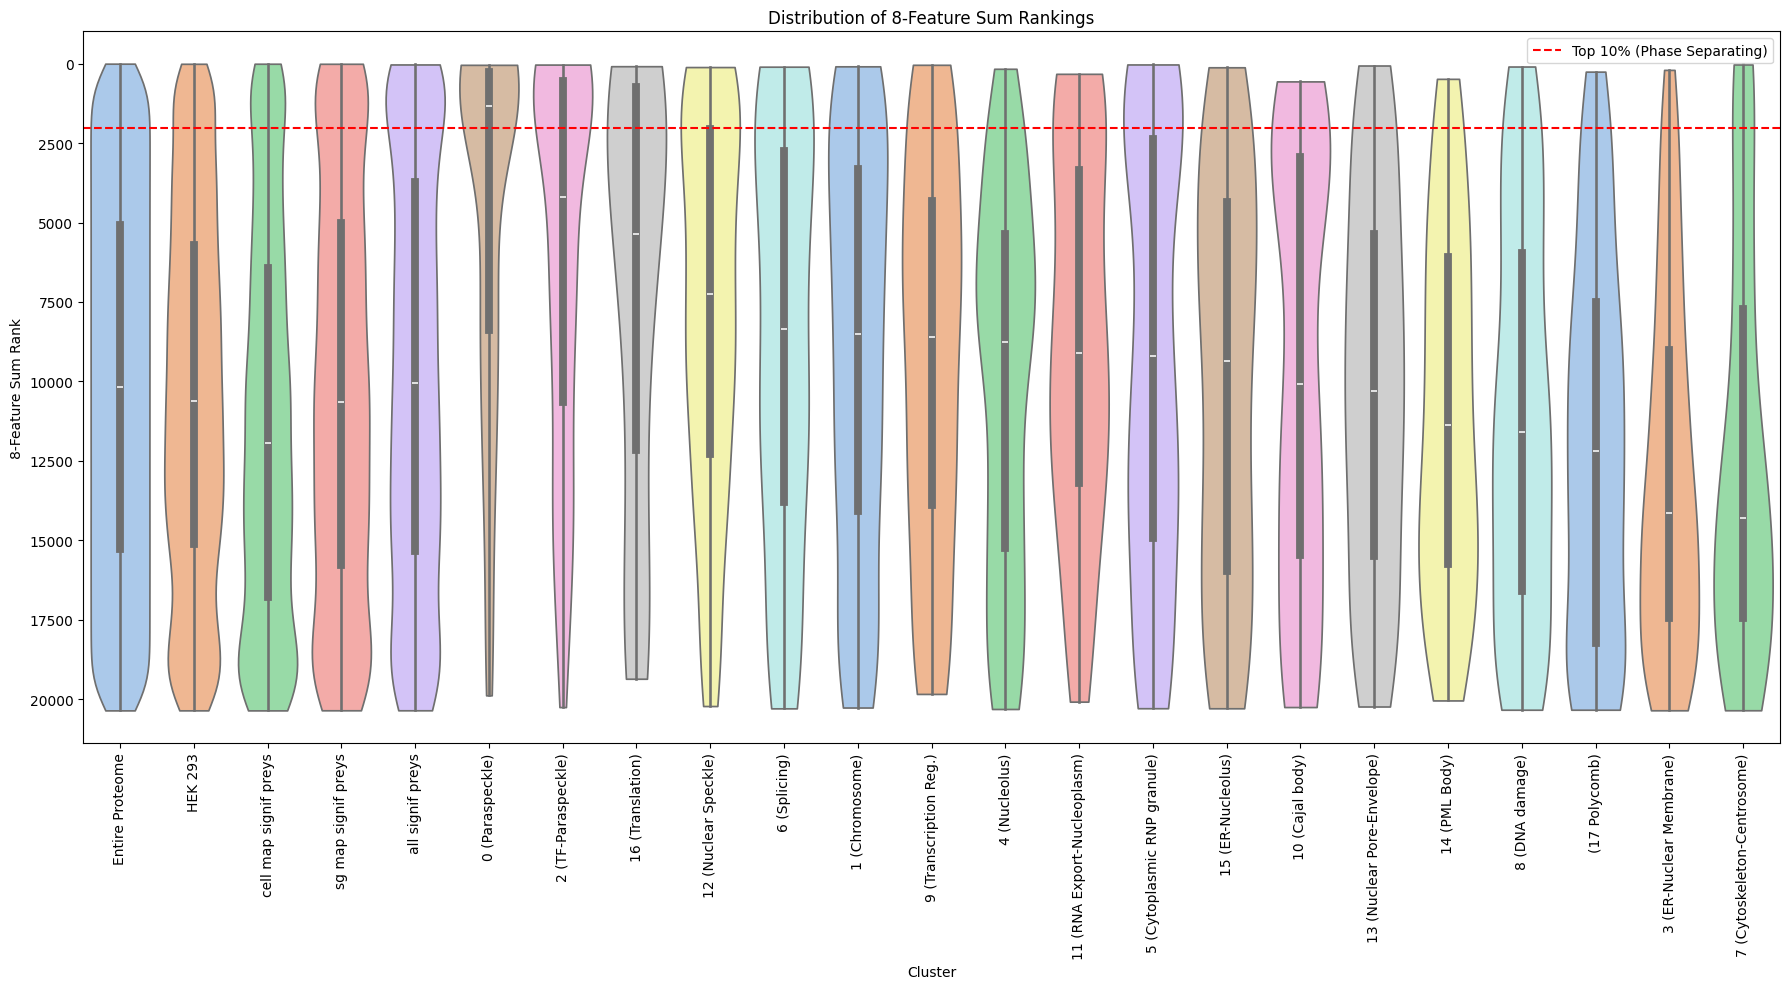

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Set working directory
os.chdir('/content/drive/MyDrive/ACG Lab/Dyakov et al 2023 (google drive version)/v2_dataset/LLPS prediction')

# Configure Matplotlib to not convert text to paths in SVG output
plt.rcParams['svg.fonttype'] = 'none'

# Load input files
clusters_df = pd.read_csv('7013_cleaned_v2_NMF_19_top10-07-005_clusters_plus_datasets.csv')
rna_df = pd.read_csv('rna_celline.csv')
feature_df = pd.read_csv('LLPhyScore_TS3_IDtoGene.csv')

# Display column names of clusters_df for debugging
print(f"Columns in clusters_df: {clusters_df.columns}")

# Normalize gene identifiers to uppercase and strip whitespaces
feature_df['tag'] = feature_df['tag'].str.upper().str.strip()
for column in clusters_df.columns:
    clusters_df[column] = clusters_df[column].str.upper().str.strip()

# Normalize RNA data identifiers and strip whitespaces
rna_df['Gene name'] = rna_df['Gene name'].str.upper().str.strip()

# Dictionary mapping indices to new cluster names
cluster_names = {
    0: '0 (Paraspeckle)', 1: '1 (Chromosome)', 2: '2 (TF-Paraspeckle)', 3: '3 (ER-Nuclear Membrane)', 4: '4 (Nucleolus)',
    5: '5 (Cytoplasmic RNP granule)', 6: '6 (Splicing)', 7: '7 (Cytoskeleton-Centrosome)', 8: '8 (DNA damage)',
    9: '9 (Transcription Reg.)', 10: '10 (Cajal body)', 11: '11 (RNA Export-Nucleoplasm)', 12: '12 (Nuclear Speckle)',
    13: '13 (Nuclear Pore-Envelope)', 14: '14 (PML Body)', 15: '15 (ER-Nucleolus)', 16: '16 (Translation)', 17: '(17 Polycomb)',
    18: '18 (Other/DNA binding)', 19: 'cell map signif preys', 20: 'sg map signif preys', 21: 'all signif preys'
}

# Rank genes by 8-feature sum in descending order
feature_df['8-feature Rank'] = feature_df['8-feature sum'].rank(ascending=False, method='min')
feature_df['Cluster'] = None  # Initialize the 'Cluster' column

# Debugging Information for Gene Assignment
cluster_debug_info = []

# Assign clusters from clusters_df explicitly, excluding special clusters
special_clusters = ['cell map signif preys', 'sg map signif preys', 'all signif preys']
plot_data = []
for idx, column in enumerate(clusters_df.columns):
    if column not in special_clusters:
        proteins = clusters_df[column].dropna().str.strip()
        cluster_name = cluster_names.get(idx, column)
        cluster_df = feature_df[feature_df['tag'].isin(proteins)][['8-feature Rank']].copy()
        cluster_df['Cluster'] = cluster_name
        plot_data.append(cluster_df)
        feature_df.loc[feature_df['tag'].isin(proteins), 'Cluster'] = cluster_name
        assigned_genes_count = len(cluster_df)
        total_genes_count = len(proteins)
        cluster_debug_info.append(f"{cluster_name}: Assigned {assigned_genes_count} out of {total_genes_count}")
        print(f"Immediately after assignment, {cluster_name} has {assigned_genes_count} entries")

# Merge RNA data into the feature dataframe
rna_filtered = rna_df[(rna_df['Sample'] == 'HEK 293') & (rna_df['Value'] >= 2.5)]
rna_genes = rna_filtered['Gene name'].unique()
hek_df = feature_df[feature_df['tag'].isin(rna_genes)][['8-feature Rank']].copy()
hek_df['Cluster'] = 'HEK 293'
plot_data.append(hek_df)
feature_df.loc[feature_df['tag'].isin(rna_genes), 'Cluster'] = 'HEK 293'
assigned_genes_count = len(hek_df)
total_genes_count = len(rna_genes)
cluster_debug_info.append(f"HEK 293: Assigned {assigned_genes_count} out of {total_genes_count}")
print(f"Prepared HEK 293 for plotting with {assigned_genes_count} entries")

# Add special clusters directly
for cluster in special_clusters:
    proteins = clusters_df[cluster].dropna().str.strip()
    special_df = feature_df[feature_df['tag'].isin(proteins)][['8-feature Rank']].copy()
    special_df['Cluster'] = cluster.replace('_', ' ')
    plot_data.append(special_df)
    feature_df.loc[feature_df['tag'].isin(proteins), 'Cluster'] = cluster.replace('_', ' ')
    assigned_genes_count = len(special_df)
    total_genes_count = len(proteins)
    cluster_debug_info.append(f"{cluster.replace('_', ' ')}: Assigned {assigned_genes_count} out of {total_genes_count}")
    print(f"Prepared {cluster.replace('_', ' ')} for plotting with {assigned_genes_count} entries")

# Add 'Entire Proteome' first
proteome_df = feature_df[['8-feature Rank']].copy()
proteome_df['Cluster'] = 'Entire Proteome'
plot_data = [proteome_df] + plot_data
assigned_genes_count = len(proteome_df)
total_genes_count = len(feature_df)
cluster_debug_info.append(f"Entire Proteome: Assigned {assigned_genes_count} out of {total_genes_count}")
print(f"Prepared Entire Proteome for plotting with {assigned_genes_count} entries")

# Sorting clusters 0 to 18 by median 8-feature Rank in descending order
sorted_temp_data = sorted(plot_data[1:-5], key=lambda x: x['8-feature Rank'].median(), reverse=True)

# Re-arrange plot_data with special clusters at the beginning
special_gene_sets_ordered = ['Entire Proteome', 'HEK 293', 'all signif preys', 'cell map signif preys', 'sg map signif preys']
special_data = [df for df in plot_data if df['Cluster'].unique()[0] in special_gene_sets_ordered]
plot_data = special_data + sorted_temp_data[::-1]

# Debugging Output
print(f'Clusters in plot_data: {[df["Cluster"].unique()[0] for df in plot_data if len(df) > 0]}')
print('\n'.join(cluster_debug_info))

# Concatenate all dataframes for plotting
plot_df = pd.concat(plot_data)

# Debugging Output
print(f'Clusters in plot_df: {plot_df["Cluster"].unique()}')

# Plot violin plot
plt.figure(figsize=(18, 10))
sns.violinplot(x='Cluster', y='8-feature Rank', data=plot_df, palette='pastel', cut=0)

# Invert y-axis to place highest scores at the top
plt.gca().invert_yaxis()

# Add a dashed line to indicate the top 10% rank
top_10_percent_rank = int(len(feature_df) * 0.1)
plt.axhline(top_10_percent_rank, color='red', linestyle='--', label='Top 10% (Phase Separating)')
plt.legend()

plt.title('Distribution of 8-Feature Sum Rankings')
plt.xlabel('Cluster')
plt.ylabel('8-Feature Sum Rank')
plt.xticks(rotation=90)
plt.tight_layout()

# Save figures
plt.savefig('8_feature_sum_violin_rank_inverted.png', dpi=300)
plt.savefig('8_feature_sum_violin_rank_inverted.svg', dpi=300)
plt.show()


#statistical analysis of clusters plotted (results found in Supp. Table 5)

## Explanation


*   Mann-Whitney U Test: This non-parametric test is used because it does not assume normal distribution of the data. It's suitable for comparing two independent samples.
*   FDR Adjustment: We use the Benjamini-Hochberg procedure to control the false discovery rate, which is more appropriate for biological data where rejecting true null hypotheses (discovering true effects) is more important.
*   Significance Cutoffs: Typically, an FDR-adjusted p-value of ≤ 0.05 is considered statistically significant. This means that we expect no more than 5% of all significant tests to be false discoveries.

## Interpretation / output

U-statistic:
* This is the statistic from the Mann-Whitney U test. The U-statistic represents the number of successes (i.e., how many times a value from the first group was greater than a value from the second group when all observations are ranked together). It’s a measure of the magnitude of difference between the distributions of the two groups.
* A larger U-statistic generally indicates a greater difference between the two groups, but it is heavily dependent on sample size.

P-value:
* This value represents the probability that the observed difference (or a more extreme difference) would occur if the two groups were actually the same (i.e., under the null hypothesis). A smaller p-value indicates that the observed data are unlikely under the null hypothesis.
* P-values are raw here, meaning they do not account for the multiple comparisons made in the study.

P-value adjusted:
* This column shows the p-values adjusted for multiple comparisons using the Benjamini-Hochberg procedure, which controls the False Discovery Rate (FDR). This adjustment is crucial when multiple tests are conducted, as it reduces the likelihood of false positives.
* Adjusted p-values provide a more accurate indication of whether the differences observed are statistically significant across the dataset. An adjusted p-value ≤ 0.05 is commonly used as a threshold for declaring statistical significance.

Significant:
* This is a boolean (True/False) column that indicates whether the test result is considered statistically significant based on the adjusted p-value. A result is typically marked as significant if the adjusted p-value is ≤ 0.05.
* If True, it suggests that there is a statistically significant difference between the disorder percentages of the two groups being compared. If False, there isn't enough evidence to suggest a significant difference at the 5% significance level.


In [ ]:
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Assuming 'plot_df' from your previous code is still in memory

# Function to perform Mann-Whitney U tests
def perform_tests(df, groups):
    results = []
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            group1 = df[df['Cluster'] == groups[i]]['Disorder Percentage']
            group2 = df[df['Cluster'] == groups[j]]['Disorder Percentage']
            stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
            results.append({'Group1': groups[i], 'Group2': groups[j], 'U-statistic': stat, 'P-value': p})
    return results

# List of all clusters including special datasets
clusters = list(plot_df['Cluster'].unique())

# Perform the tests
test_results = perform_tests(plot_df, clusters)

# Convert results to DataFrame
results_df = pd.DataFrame(test_results)

# Adjust p-values for multiple comparisons (FDR Benjamini-Hochberg)
rejected, p_adjusted, _, _ = multipletests(results_df['P-value'], alpha=0.05, method='fdr_bh')
results_df['P-value adjusted'] = p_adjusted
results_df['Significant'] = rejected

# Save to CSV
results_df.to_csv('statistical_comparisons.csv', index=False)

print("Results saved to 'statistical_comparisons.csv'.")


Results saved to 'statistical_comparisons.csv'.


# Convert LLPhyScore supp table 3 uniprot IDs to gene names

Data pre-processing step

In [ ]:
import os
import csv

def parse_fasta(fasta_file_path):
    """ Parses the FASTA file to extract Uniprot ID to Gene name mapping, formatted to match CSV IDs. """
    uniprot_to_gene = {}
    with open(fasta_file_path, 'r') as file:
        for line in file:
            if line.startswith('>'):
                try:
                    parts = line.split('|')
                    uniprot_id = parts[1] + '_' + parts[2].split(' ')[0]
                    gene_name = next((part[3:] for part in line.split() if part.startswith('GN=')), None)
                    if gene_name:
                        uniprot_to_gene[uniprot_id] = gene_name
                except Exception as e:
                    print(f"Error parsing line: {line.strip()} | Error: {e}")
    print("Sample dictionary entries:", list(uniprot_to_gene.items())[:5])
    return uniprot_to_gene

def update_csv_with_genes(csv_file_path, output_csv_file_path, uniprot_to_gene):
    """ Update CSV by replacing Uniprot IDs with gene names in column 0. """
    with open(csv_file_path, 'r', newline='') as infile, open(output_csv_file_path, 'w', newline='') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        unmatched_ids = []  # To log unmatched IDs
        for row in reader:
            uniprot_id = row[0]
            if uniprot_id in uniprot_to_gene:
                print(f"Match found: {uniprot_id} -> {uniprot_to_gene[uniprot_id]}")  # Debug: Print match
                row[0] = uniprot_to_gene[uniprot_id]
            else:
                unmatched_ids.append(uniprot_id)
                print(f"No match for: {uniprot_id}")  # Debug: Print no match
            writer.writerow(row)
        print(f"Unmatched IDs: {list(set(unmatched_ids))[:20]}")  # Print unmatched IDs

# Set directory for files
os.chdir('/content/drive/MyDrive/ACG Lab/Dyakov et al 2023 (google drive version)/v2_dataset/LLPS prediction')

# Usage
fasta_file = 'File_S4_20380 human sequences.fasta'
csv_file = 'LLPhyScore_TS3.csv'
output_csv_file = 'LLPhyScore_TS3_IDtoGene.csv'

uniprot_to_gene_map = parse_fasta(fasta_file)
update_csv_with_genes(csv_file, output_csv_file, uniprot_to_gene_map)
